#  Edge Graph Convolutional NN for  Jet tagging using jet constituents from HLS data using node self-reccurrence

This NN is inspired by Dynamic Graph CNN for Learning on Point Clouds (DGCNN) but uses only a single Conv1D layer to get an embedded respresentation for points and edges and applies a MLP to classify the Graph based on embbeded representation. It can be extended adding more Conv1D and new KNN graphs defined on embedded spaces , but we didn't do it because the NN gets too large for HLS L1 trigger aplications  

## Author: Andre Sznajder


## Inspired by:

`Jet Tagging via Particle Clouds by Huilin Qu & Loukas Gouskos` ( https://arxiv.org/pdf/1902.08570.pdf )
https://github.com/hqucms/ParticleNet/blob/master/tf-keras/tf_keras_model.py

`Particle NET for Particle Characterization`
https://github.com/pnnl/particle-net

`Dynamic Graph CNN for Learning on Point Clouds (DGCNN)` 
https://github.com/WangYueFt/dgcnn/tree/master/tensorflow

## Also inspired by SPEKTRAL implementation which uses a MLP instead of CONV:
Both aproaches are equivalent when using aplying convolution on each node individually
https://graphneural.network/layers/convolution/#edgeconv



# Load train and test JetID datasets as numpy arrays 

In [2]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 8

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/X_train_val_nconst_8.npy'

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



## Define KNN algorithm to find nearest node neightbours 

In [4]:
import tensorflow as tf
from tensorflow import keras


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def knn_diff(X,K):
    """EdgeConv
    Args:
        K: int, number of neighbors
    Inputs:
        X: point features (eta, phi, Pt)
    Returns:
        neighbours features differences
    """

    # Define node coordinates and features ( original ParticleNET uses only Pt as node features ! )
    pts = X[:,:,1:3] # (Eta,Phi) coordinates of points ( graph nodes )
    fts = X          # (Pt,Eta,Phi) node features ( graph node features )
    num_points = X.shape[1]

    # distance
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)

    # Finds nodes nearest neighbours features differences
    knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  
    knn_fts = tf.subtract(knn_fts, knn_fts_center)  # (N, P, K, C)

    return knn_fts



## Define EdgeGraphConv Model 

EdgeGraphConv implements a modified version of DGCNN where we use a Conv1D instead of a Conv2D in order to define the convolution over the graph nodes and edges. Notice that a Conv1D layer uses a kernel_size=1 and stride=1 over the nodes(edges), so it's equivalent to apply a MLP to agregate the  nodes(edges) features. In Spektral EdgeConv uses directly an MLP for that. 

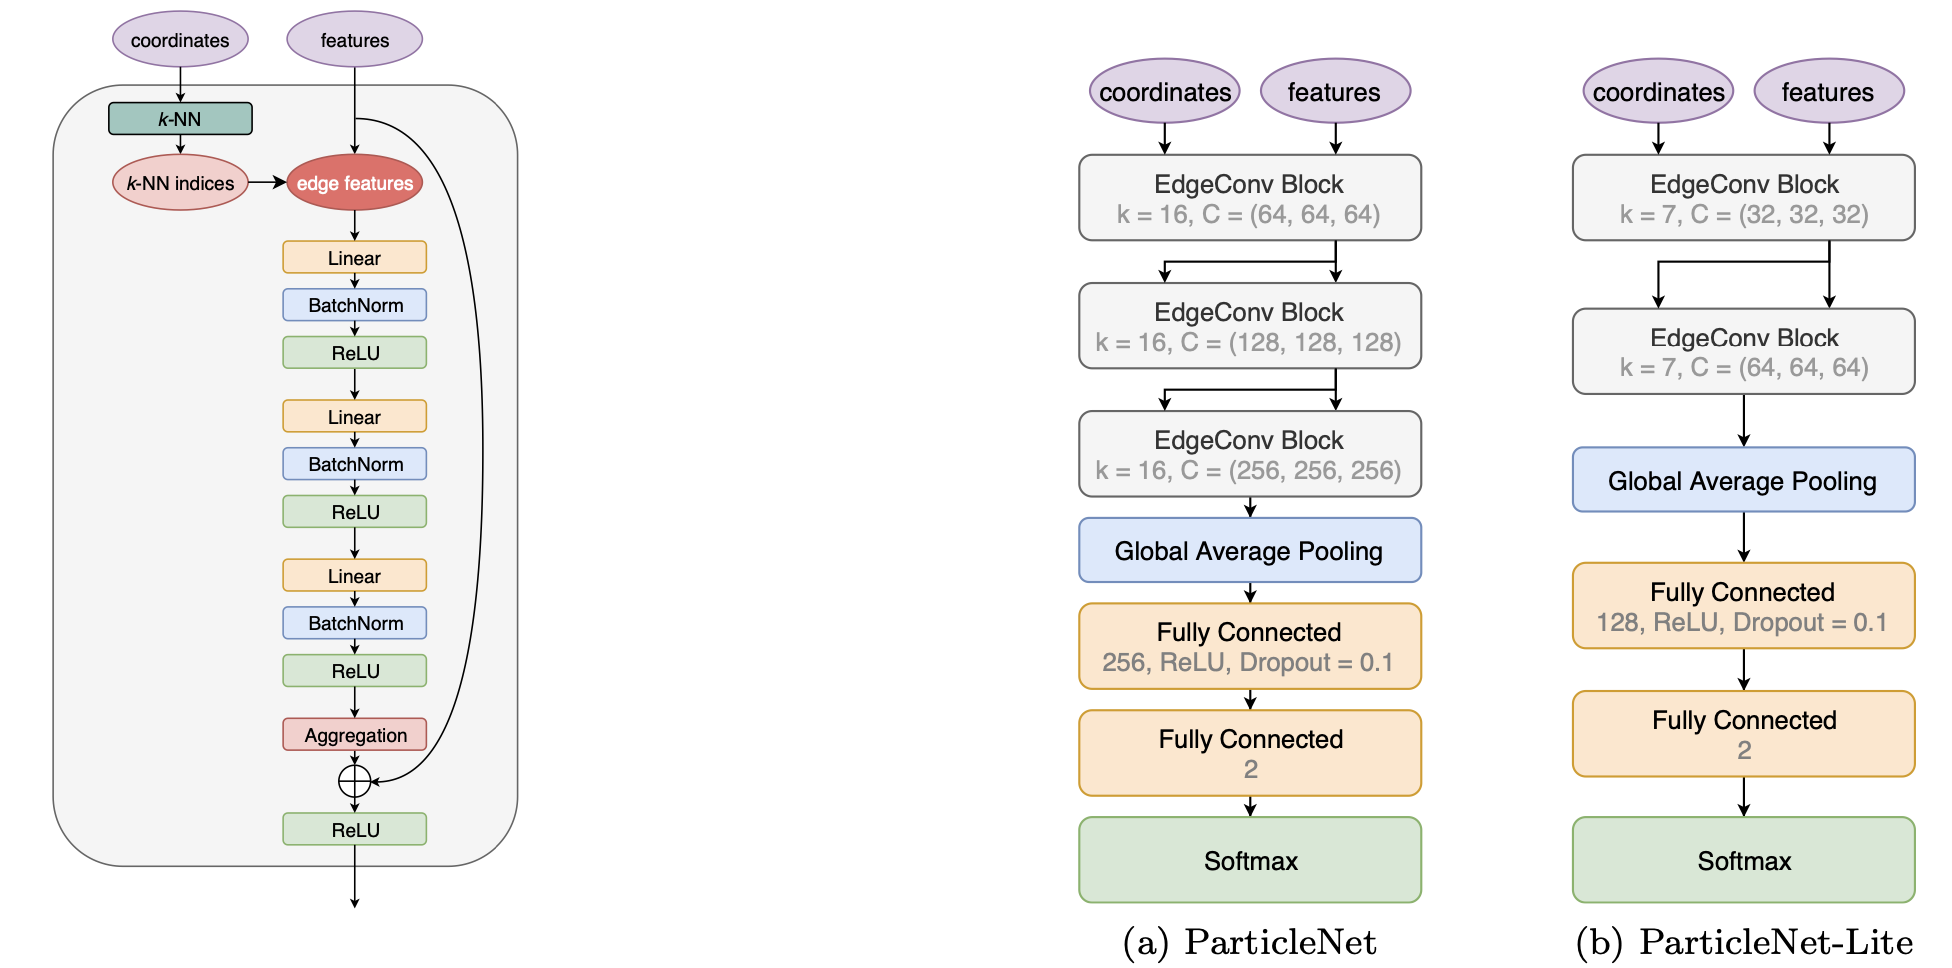


In [5]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten 
from tensorflow.keras import utils

###########################################################################
# Define DynamicGraphConv Model 

'''
# For 32 constituents
point_channels=8   
edge_channels = 2  
nhidden = int(nconstit*nfeat/2) 
k=4                
'''

'''
# For 16 constituents
point_channels=16                 
edge_channels = 4   
nhidden = int(nconstit*nfeat/3.) 
k=8                 
'''

#'''
# For 8 constituents
point_channels = 30   
edge_channels  = 30   
nhidden = int(nconstit*nfeat/3.0) 
k=7                   
#'''

##############################################################################
ntargets = 5

# Instantiate Tensorflow input tensors in Batch mode 
in_points = Input(shape=(nconstit,nfeat), name="in_points")

# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm_points')(in_points)

# Conv1D with kernel_size=nfeatures to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)
h_points = Conv1D(point_channels, kernel_size=1, strides=1
                  , activation="relu"
                  , use_bias=True
                  , name='Conv1D_points')(h)

# Instantiate Tensorflow input tensors in Batch mode 
in_edges = Input(shape=(nconstit,k*nfeat), name="in_edges")


# Input edges features BatchNormalization 
h = BatchNormalization(name='BatchNorm_edges')(in_edges)

# Conv1D with kernel_size=nfeatures to implement a MLP, taking neighbouring nodes 
#   features differences as edges features 

h_edges  = Conv1D(edge_channels, kernel_size=1, strides=1
                  , activation='relu'
                  , use_bias=True
                  , name='Conv1D_edges')(h)

# Concatenate points+edge features                           
#        out = Activation(activation, name='Activation_features')(sc + fts)  # (N, P, C')
#        out = sc+fts
h = tf.concat([h_points,h_edges],axis=2)

# reshape into MLP input (batch, nconstit*(point + edge channels))
#h = tf.reshape(h,[-1,nconstit*(point_channels+edge_channels)]) 

# Flatten to format for MLP input
h=Flatten(name='Flatten')(h)
print("MLP input h =",h)

# Dense layers for classification
h = Dense(nhidden, activation='relu')(h)
h = Dense(nhidden, activation='relu')(h)
h = Dense(nhidden, activation='relu')(h)

out = Dense(ntargets, activation='softmax')(h)  # (N, num_classes)

# Build the model
model = Model(inputs=[in_points,in_edges], outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0001)
#optim = Adam(learning_rate=0.0002)
#optim = Adam()


# Compile the Model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


MLP input h = KerasTensor(type_spec=TensorSpec(shape=(None, 480), dtype=tf.float32, name=None), name='Flatten/Reshape:0', description="created by layer 'Flatten'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 8, 21)]      0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 8, 3)         12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormali

## Run training
Here, we run the training.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('EdgeGraphConv_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
point_feats = X_train_val
diffs = knn_diff(X_train_val,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats = tf.reshape(diffs,[-1,nconstit,k*nfeat])   # reshape edges (N,nconstit*K*nfeat)
#targets = tf.expand_dims(Y_train_val,axis=1)
targets = Y_train_val



print("point_feats shape= ",point_feats.shape)
print("edge_feats shape= ",edge_feats.shape)
print("Y_train_val shape= ",Y_train_val.shape)


history = model.fit(  [point_feats, edge_feats] , targets, 
                    epochs=200, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls],
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 

# Save the model
model.save('model_EdgeGraphConv_nconst_'+str(nmax)+'.h5')

point_feats shape=  (589600, 8, 3)
edge_feats shape=  (589600, 8, 21)
Y_train_val shape=  (589600, 5)
Epoch 1/200
807/807 [==============================] - 2s 2ms/step - loss: 1.4886 - categorical_accuracy: 0.3608 - val_loss: 1.3561 - val_categorical_accuracy: 0.4319
Epoch 2/200
807/807 [==============================] - 2s 2ms/step - loss: 1.2969 - categorical_accuracy: 0.4622 - val_loss: 1.2628 - val_categorical_accuracy: 0.4833
Epoch 3/200
807/807 [==============================] - 2s 3ms/step - loss: 1.2327 - categorical_accuracy: 0.5027 - val_loss: 1.2144 - val_categorical_accuracy: 0.5219
Epoch 4/200
807/807 [==============================] - 2s 3ms/step - loss: 1.1922 - categorical_accuracy: 0.5321 - val_loss: 1.1803 - val_categorical_accuracy: 0.5421
Epoch 5/200
807/807 [==============================] - 2s 3ms/step - loss: 1.1633 - categorical_accuracy: 0.5510 - val_loss: 1.1550 - val_categorical_accuracy: 0.5575
Epoch 6/200
807/807 [==============================] - 2s 2ms/s

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

shape Y_predict = (290400, 5)


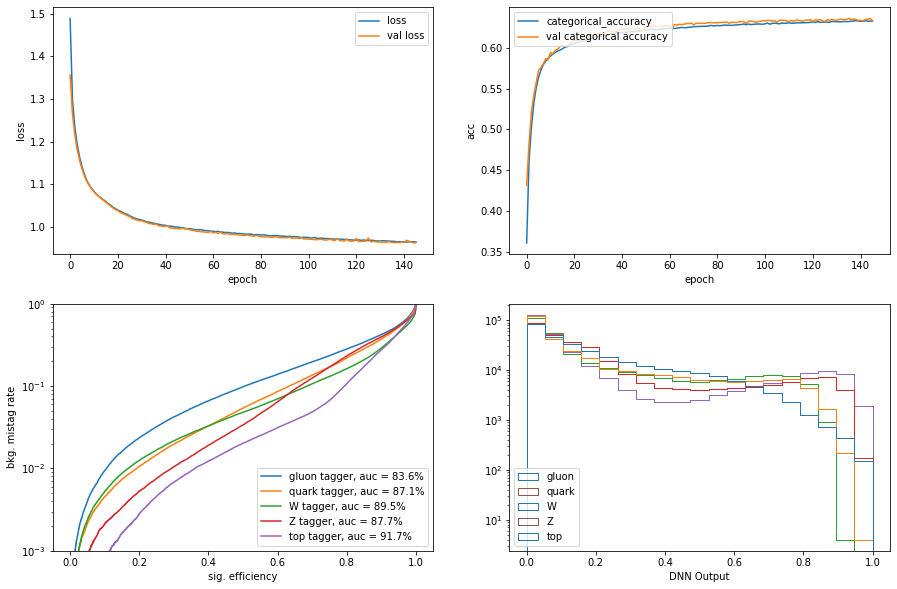

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
ax = plt.subplot(2, 2, 3)

point_feats = X_test
diffs = knn_diff(X_test,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats = tf.reshape(diffs,[-1,nconstit,k*nfeat])   # reshape edges (N,nconstit*K*nfeat)

Y_predict = model.predict([point_feats,edge_feats])
print("shape Y_predict =",Y_predict.shape)

for i, label in enumerate(labels):
#        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,0,i])
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])

        auc1[label] = auc(fpr[label], tpr[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
#    hist[name] = ax.hist(Y_predict[:,0,:], bins=X, label=name ,histtype='step')

    hist[name] = ax.hist(Y_predict[:,:], bins=X, label=name ,histtype='step')

ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()


In [8]:
# Save FPR for a given TPR value ( 30% , 50% & 80%)
model = 'EdgeGraphConv'
with open('performance_'+model+'_nconst_'+str(nmax)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
 

Label =  gluon  with treshold =  0.3
TPR =  0.3000359201546277
FPR =  0.04219249192668699
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000085524177685
FPR =  0.09803955384436291
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000273677368592
FPR =  0.28170149652707416
 
Label =  quark  with treshold =  0.3
TPR =  0.3000141582896786
FPR =  0.01966258508054862
 
Label =  quark  with treshold =  0.5
TPR =  0.5000530935862948
FPR =  0.05393422717789103
 
Label =  quark  with treshold =  0.8
TPR =  0.8000141582896786
FPR =  0.21922991414987858
 
Label =  W  with treshold =  0.3
TPR =  0.30003257496528196
FPR =  0.02163112468921417
 
Label =  W  with treshold =  0.5
TPR =  0.5000085723592848
FPR =  0.04810555299410099
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.16276774980286376
 
Label =  Z  with treshold =  0.3
TPR =  0.3000154276016936
FPR =  0.010466985258313475
 
Label =  Z  with treshold =  0.5
TPR =  0.5000257126694894
FPR =  0.0337494559666987
 
Label =